# Generative Adversarial Networks


## Vanilla GAN - MNIST

Source:
- https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [4]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)

        if format=='NHWC':
            images = images.transpose(1,3)


        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data


        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [23]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

In [11]:
class DiscriminatorNet(nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()

Generator Notes:
- Tanh maps the values to [-1,1], just like the normalized image inputs
- No dropout layers used
- 100 dimensional latent space

In [12]:
class GeneratorNet(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator = GeneratorNet()

In [13]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [15]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)

# Binary cross entropy is an implementation of log loss, which penalizes very wrong predictions
loss = nn.BCELoss()

In [16]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [17]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [20]:
def train_generator(optimizer, latent_data):
    N = latent_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(latent_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [21]:
# Static noise used to test the generator as it learns
num_test_samples = 16
test_noise = noise(num_test_samples)

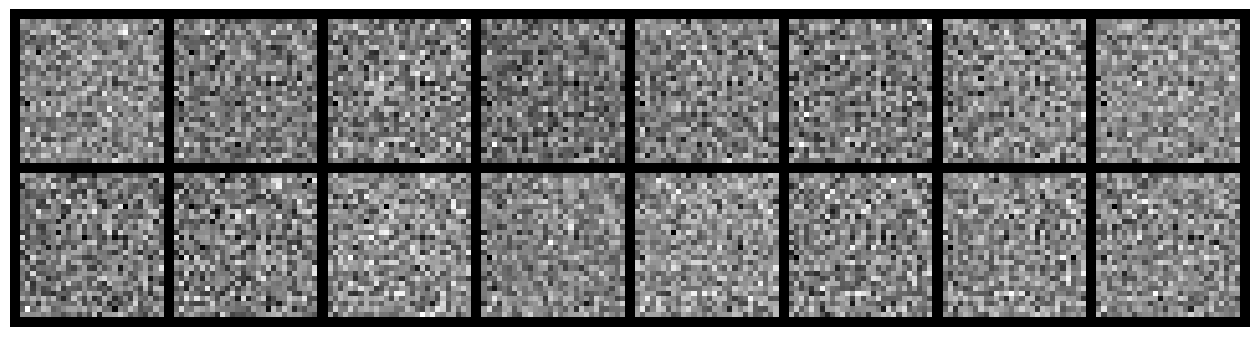

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3955, Generator Loss: 0.7136
D(x): 0.4855, D(G(z)): 0.4895


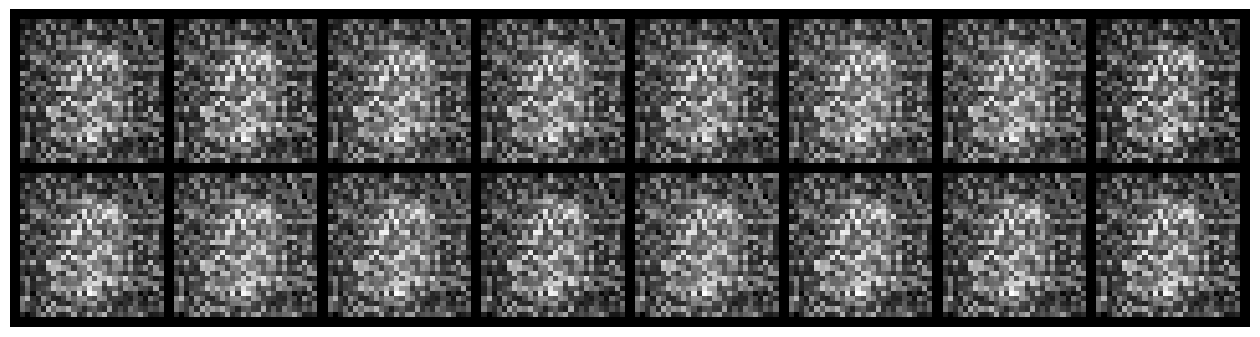

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.5554, Generator Loss: 1.1908
D(x): 0.6622, D(G(z)): 0.5598


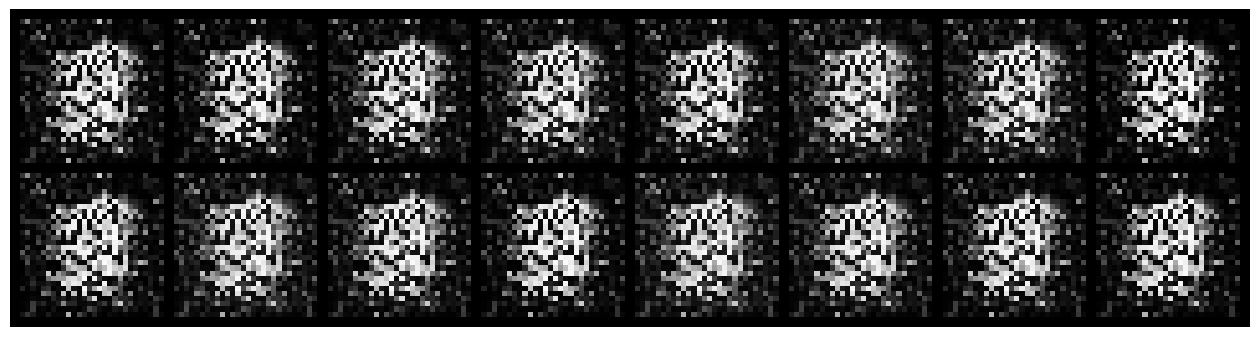

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.3404, Generator Loss: 2.5678
D(x): 0.8956, D(G(z)): 0.1907


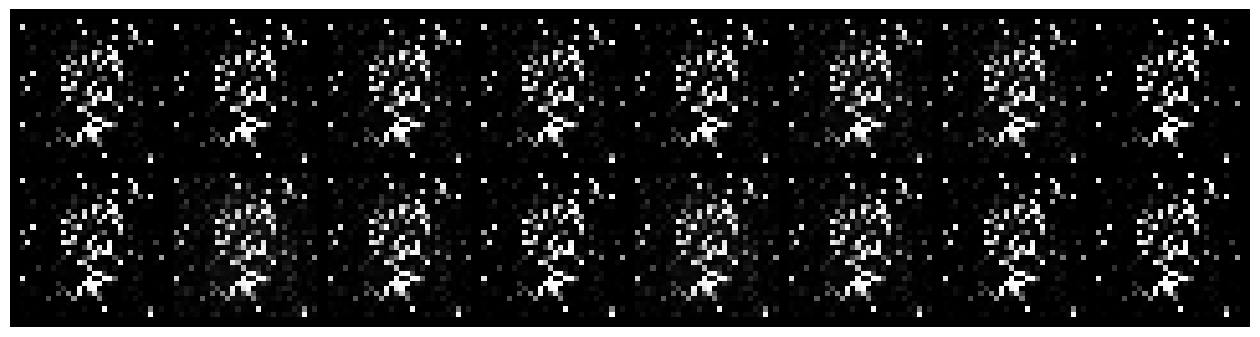

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.0255, Generator Loss: 6.8381
D(x): 0.9822, D(G(z)): 0.0059


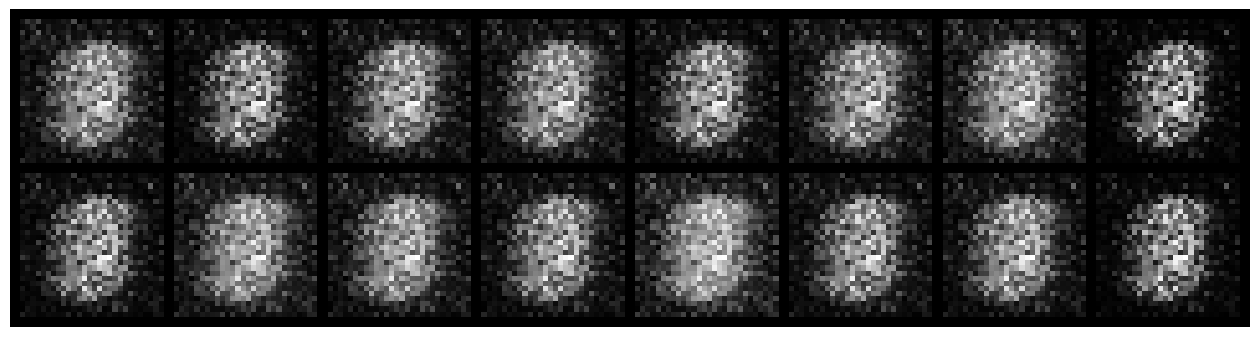

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.5588, Generator Loss: 3.8254
D(x): 0.8527, D(G(z)): 0.2627


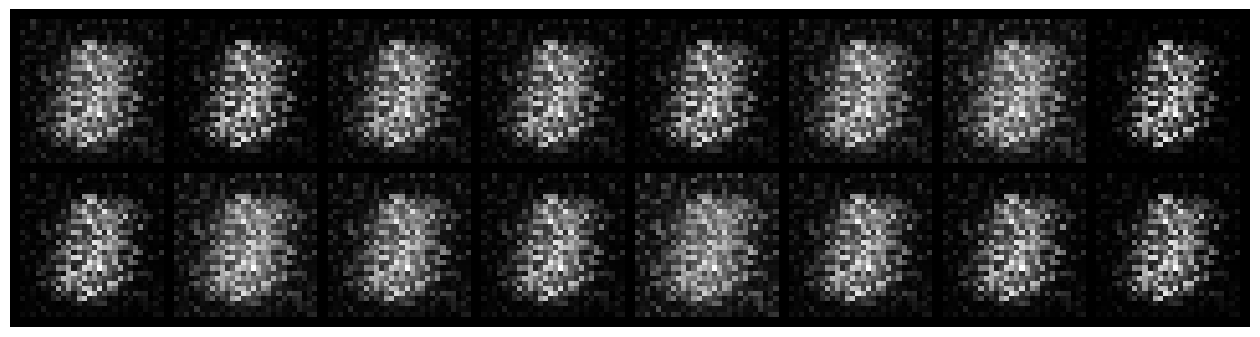

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 1.3408, Generator Loss: 0.6781
D(x): 0.5358, D(G(z)): 0.5053


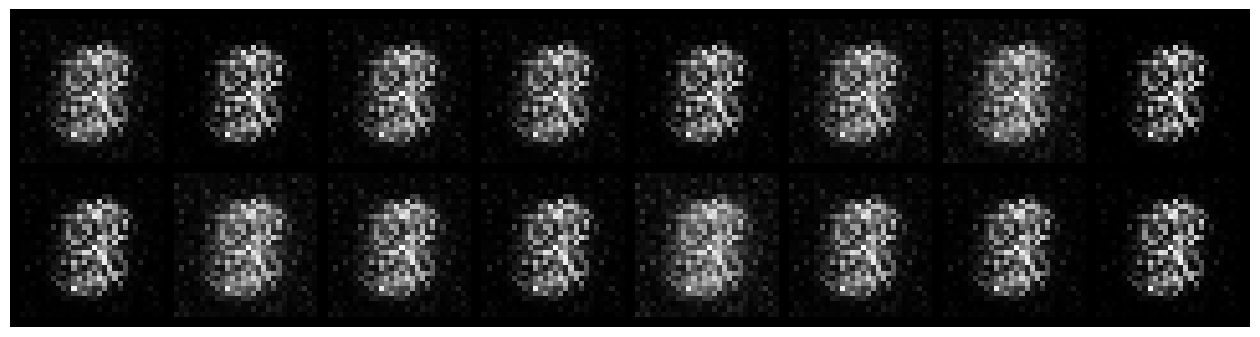

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.8332, Generator Loss: 1.3552
D(x): 0.7189, D(G(z)): 0.3412


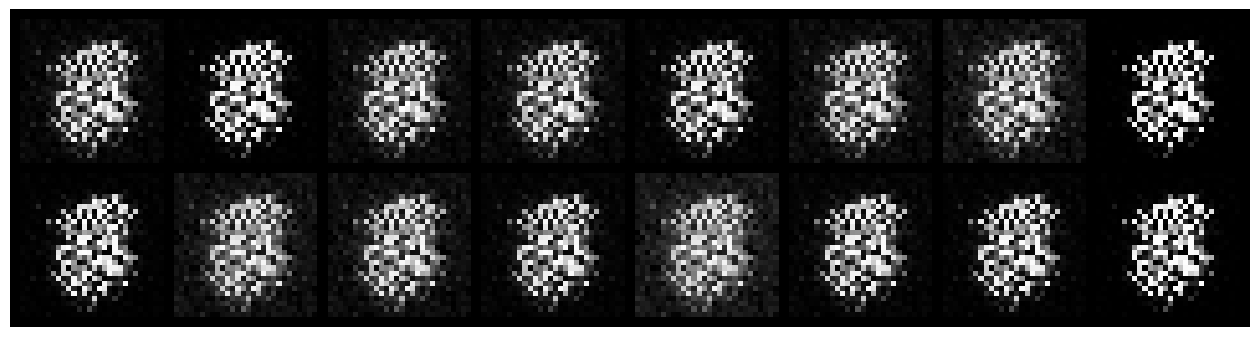

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.8200, Generator Loss: 3.1715
D(x): 0.7894, D(G(z)): 0.2753


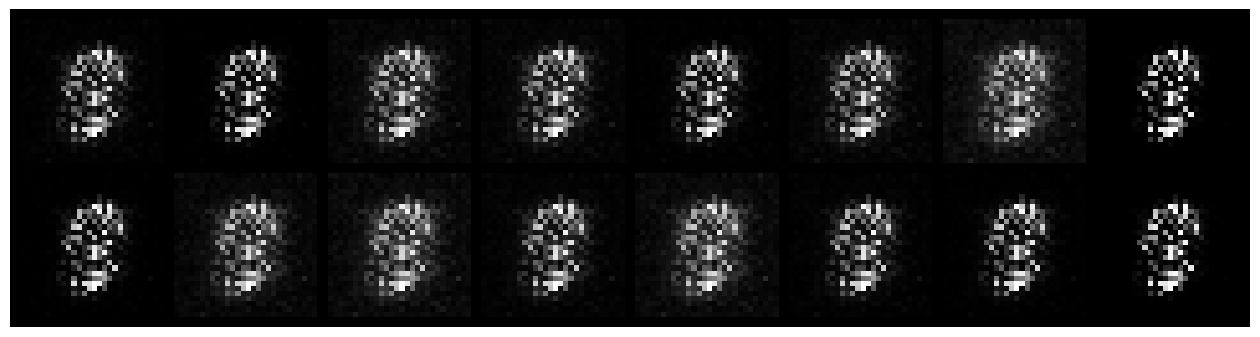

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 1.5301, Generator Loss: 1.5711
D(x): 0.5976, D(G(z)): 0.4440


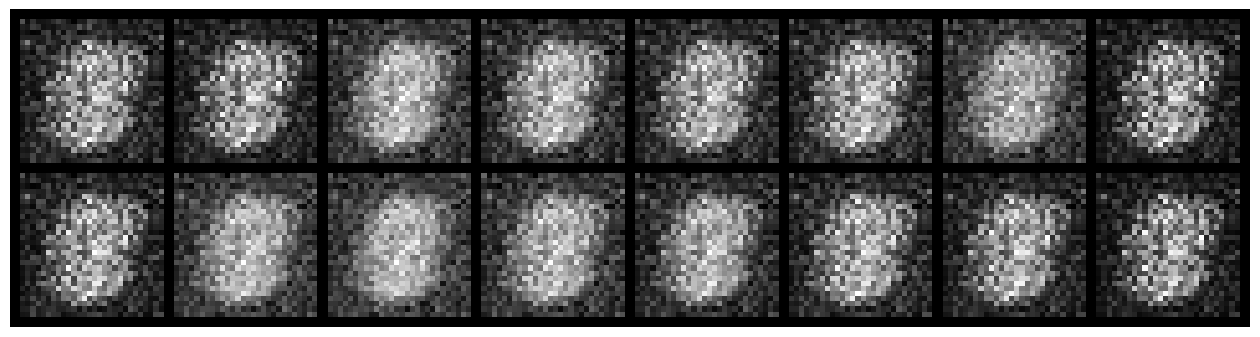

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.5611, Generator Loss: 1.5675
D(x): 0.7953, D(G(z)): 0.2693


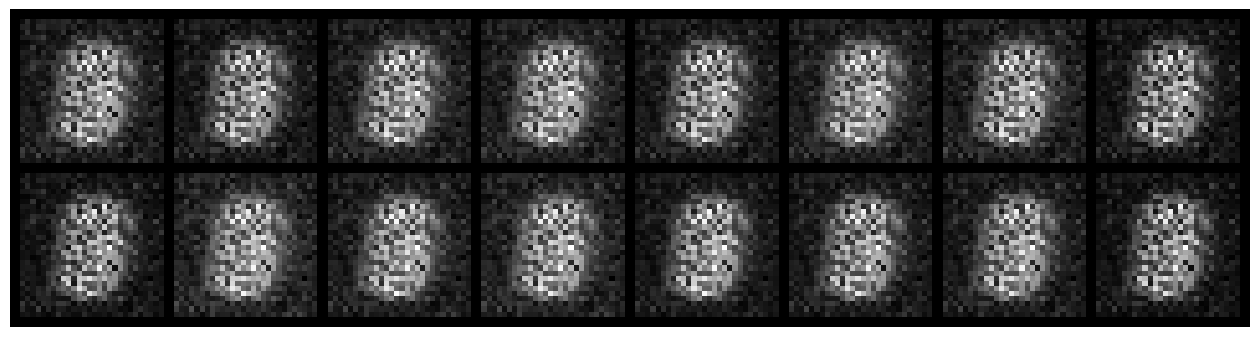

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 1.3883, Generator Loss: 1.0056
D(x): 0.6076, D(G(z)): 0.5313


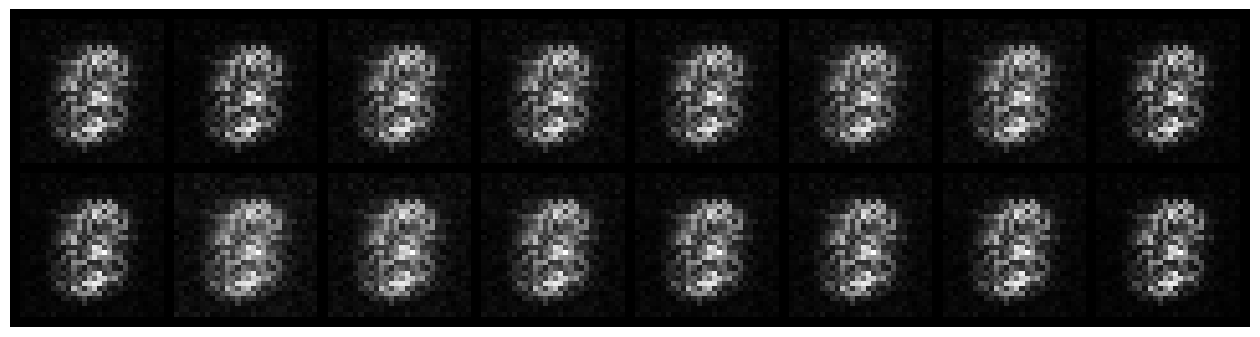

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.2162, Generator Loss: 3.1559
D(x): 0.8789, D(G(z)): 0.0764


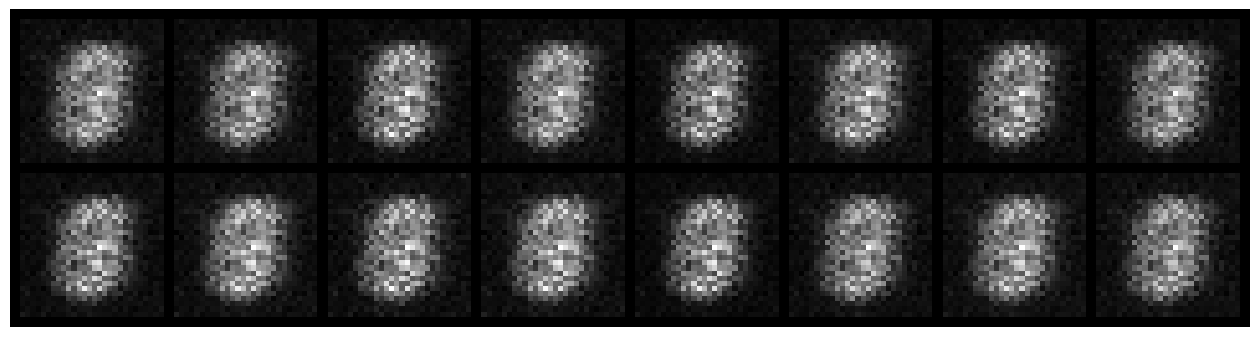

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.6884, Generator Loss: 1.5402
D(x): 0.7488, D(G(z)): 0.2679


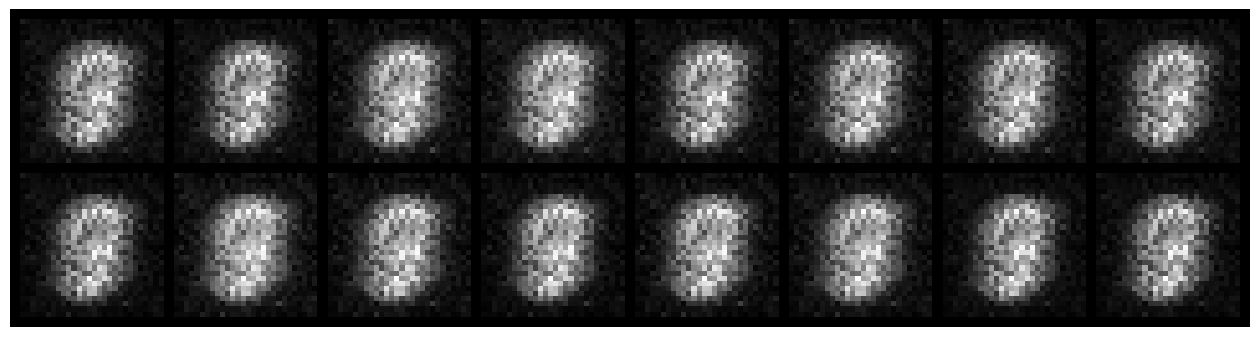

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 1.4347, Generator Loss: 0.9763
D(x): 0.6148, D(G(z)): 0.4655


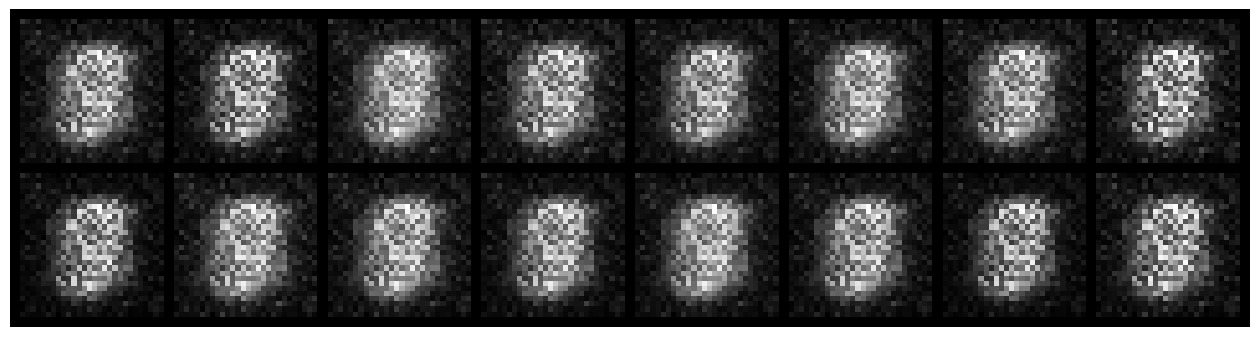

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.8683, Generator Loss: 2.0244
D(x): 0.7099, D(G(z)): 0.2544


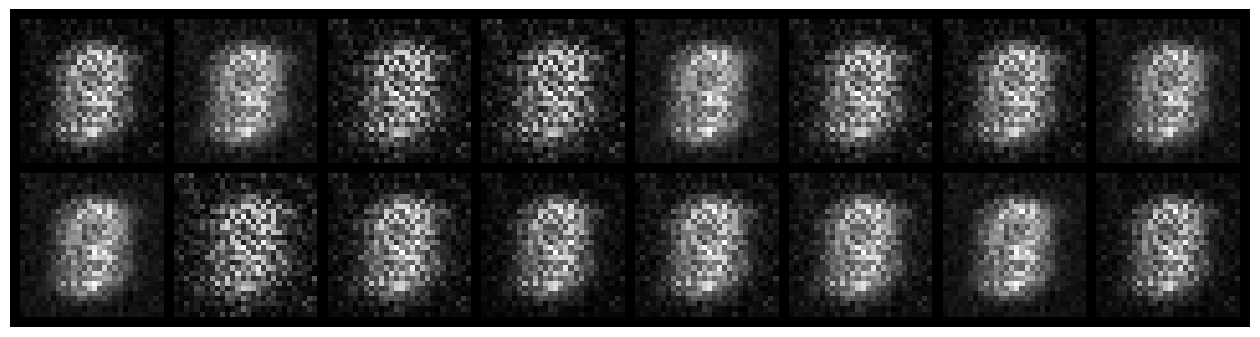

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 2.2028, Generator Loss: 0.5837
D(x): 0.5028, D(G(z)): 0.6585


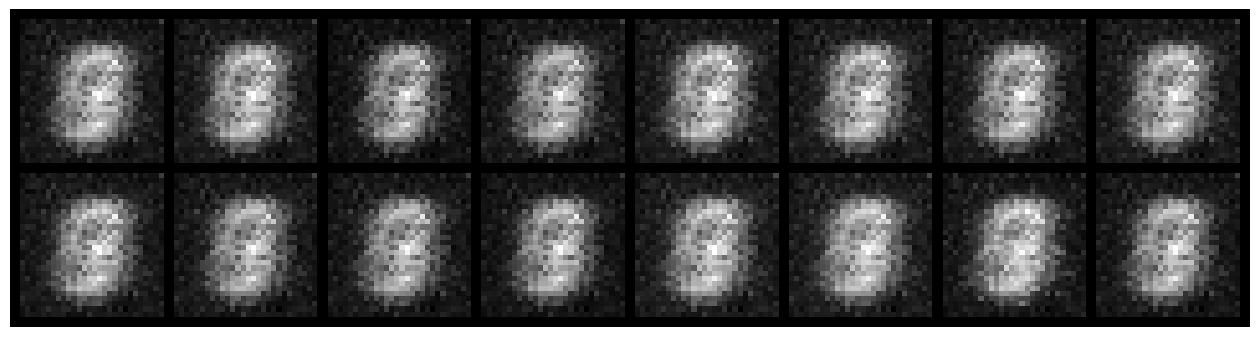

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 1.1277, Generator Loss: 1.0438
D(x): 0.6813, D(G(z)): 0.4441


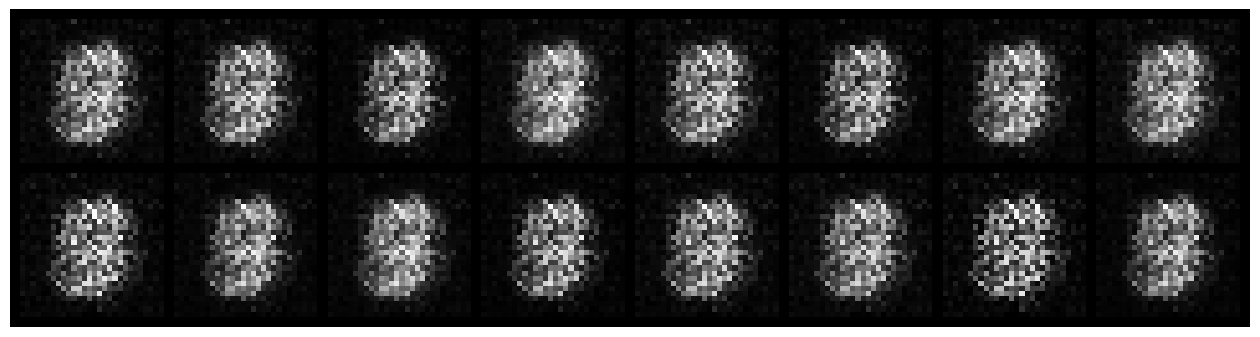

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 1.2895, Generator Loss: 0.9137
D(x): 0.6157, D(G(z)): 0.4805


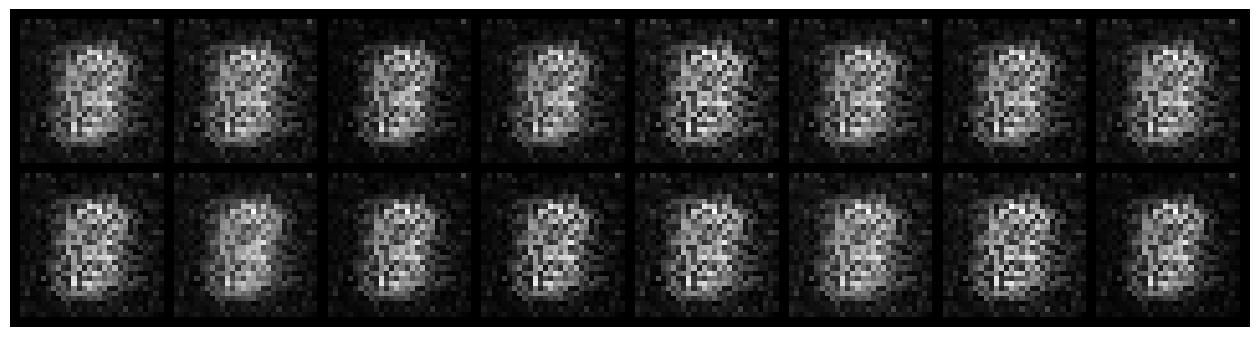

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.4664, Generator Loss: 2.8297
D(x): 0.8689, D(G(z)): 0.2309


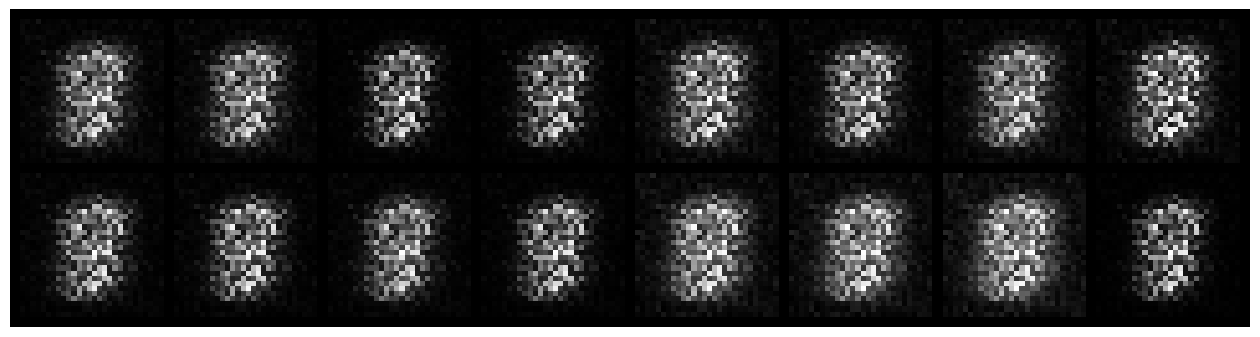

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.2746, Generator Loss: 3.9891
D(x): 0.9122, D(G(z)): 0.1230


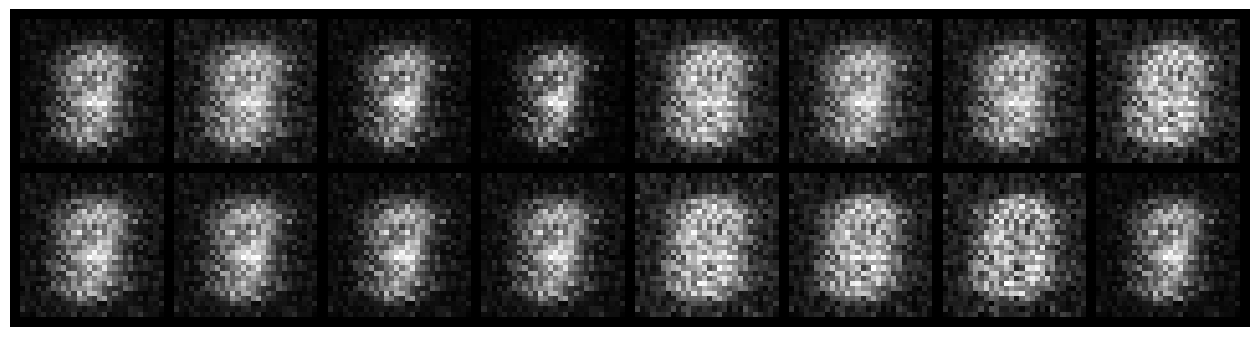

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.6137, Generator Loss: 1.6121
D(x): 0.8724, D(G(z)): 0.2964


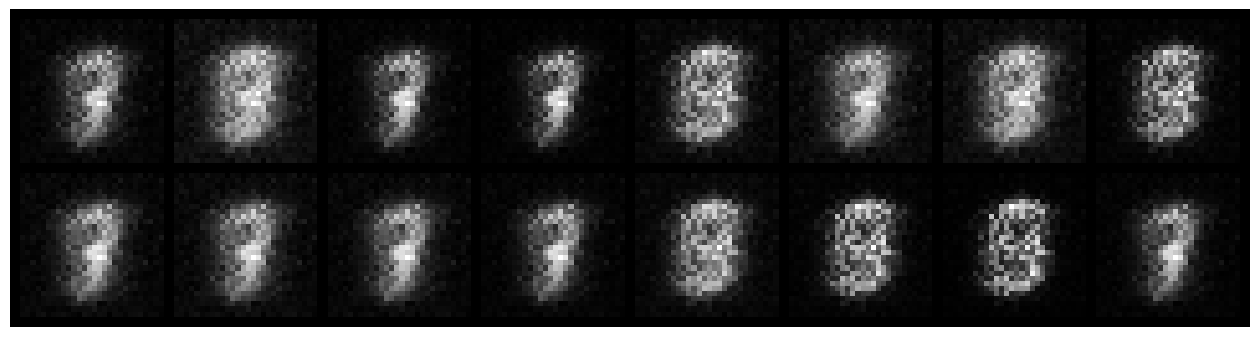

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.8134, Generator Loss: 2.0066
D(x): 0.7066, D(G(z)): 0.2106


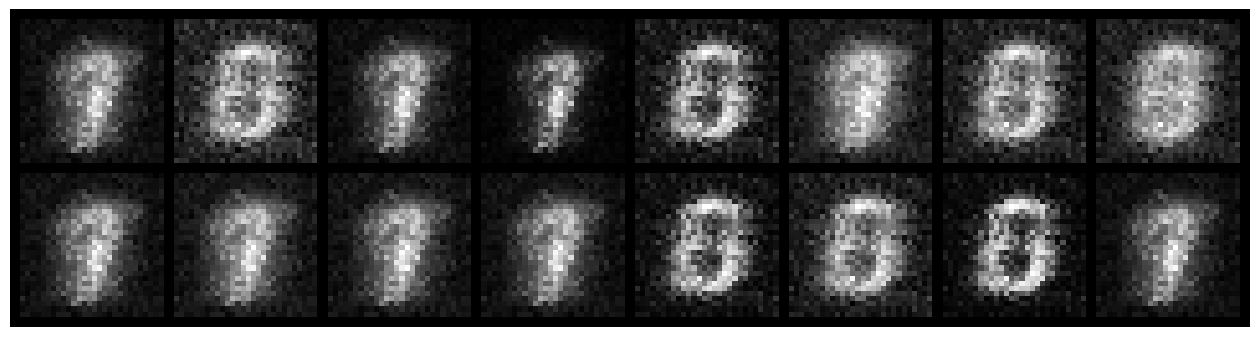

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.6222, Generator Loss: 1.6114
D(x): 0.8048, D(G(z)): 0.2852


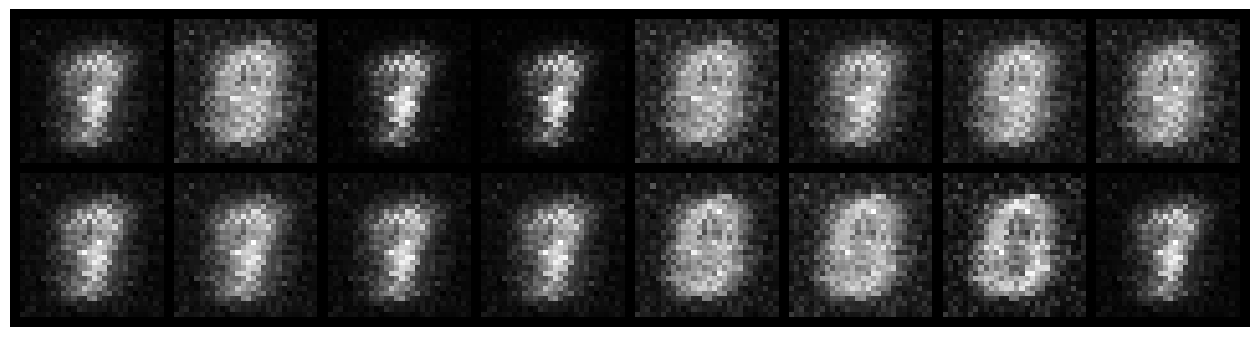

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.6012, Generator Loss: 1.6435
D(x): 0.7903, D(G(z)): 0.2051


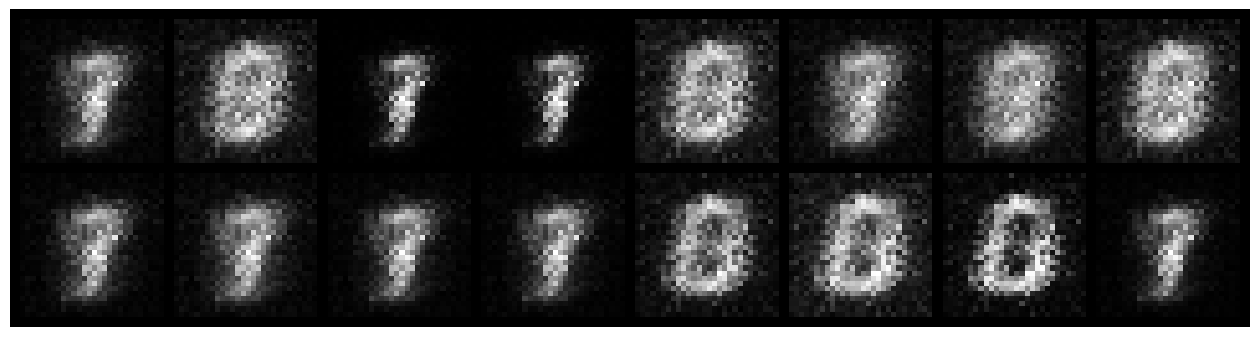

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.5879, Generator Loss: 1.8257
D(x): 0.8203, D(G(z)): 0.2324


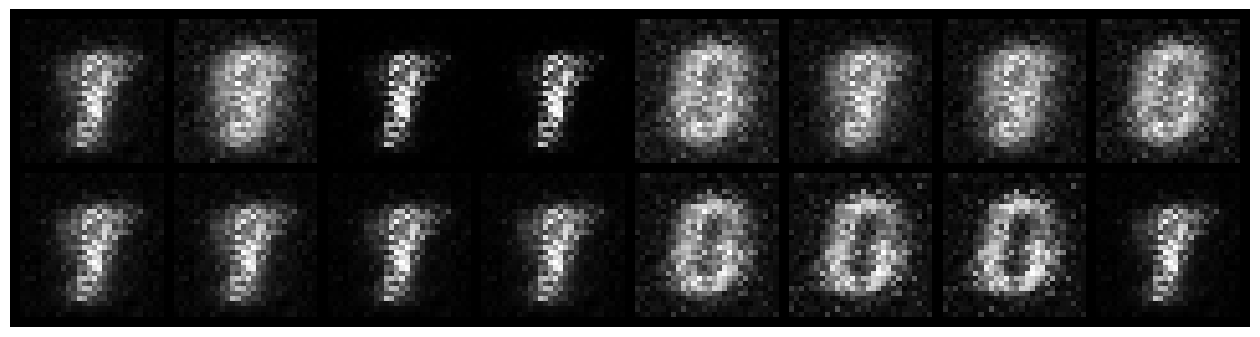

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.3698, Generator Loss: 2.7973
D(x): 0.8776, D(G(z)): 0.1257


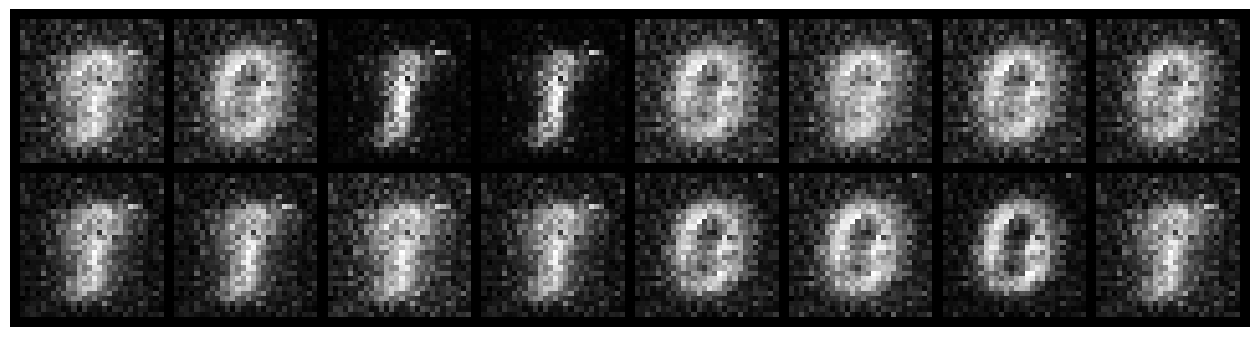

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.2938, Generator Loss: 4.3920
D(x): 0.9303, D(G(z)): 0.0825


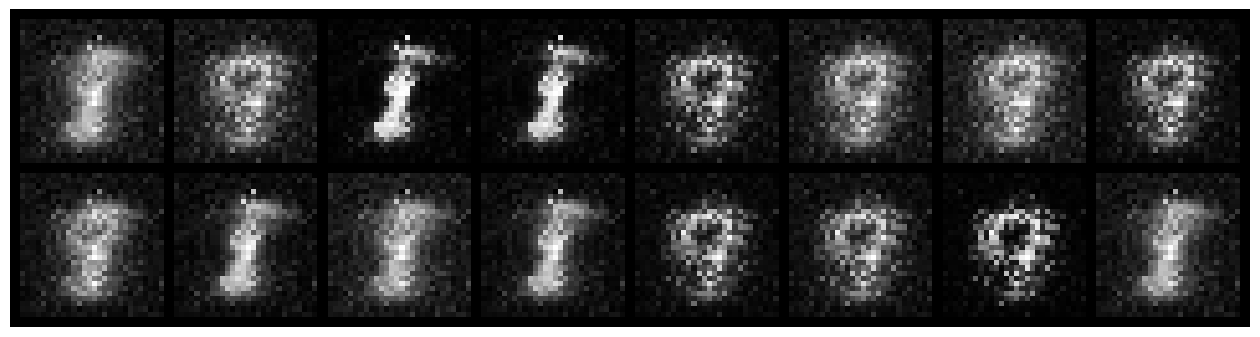

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.5906, Generator Loss: 2.1456
D(x): 0.7877, D(G(z)): 0.1325


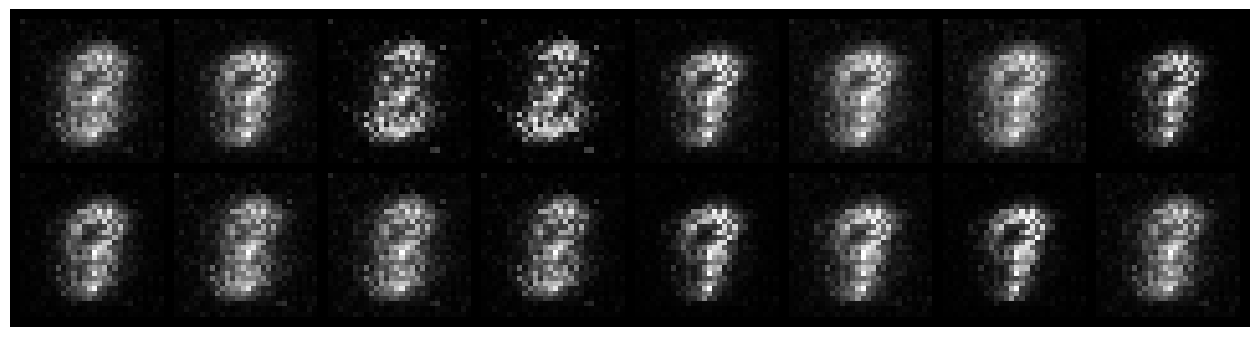

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.5532, Generator Loss: 3.1852
D(x): 0.8289, D(G(z)): 0.1540


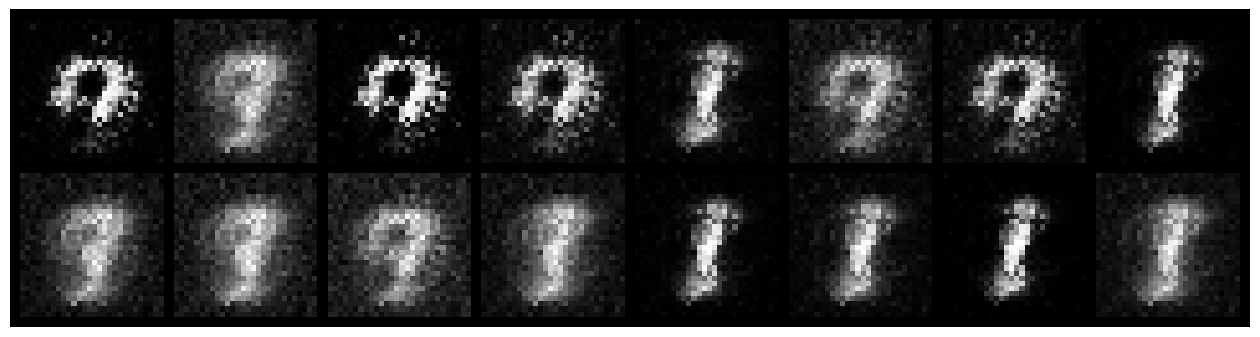

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.4687, Generator Loss: 2.3180
D(x): 0.8449, D(G(z)): 0.1793


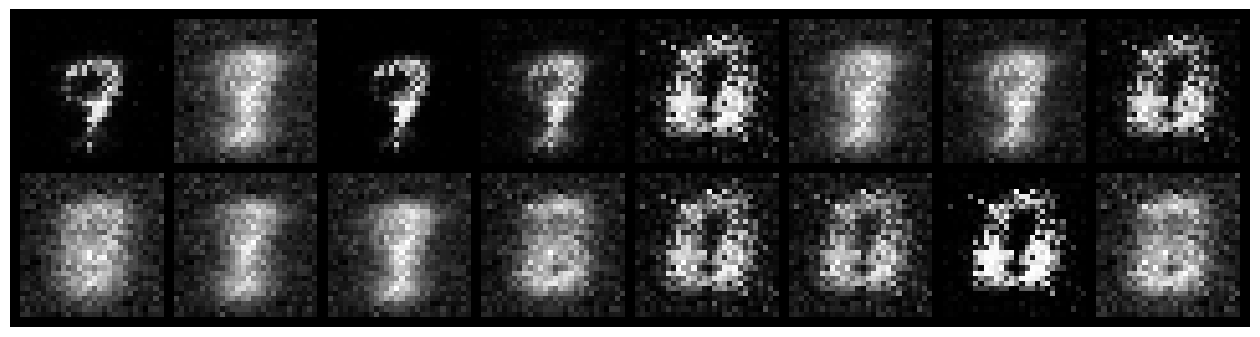

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.7496, Generator Loss: 2.5039
D(x): 0.7876, D(G(z)): 0.2018


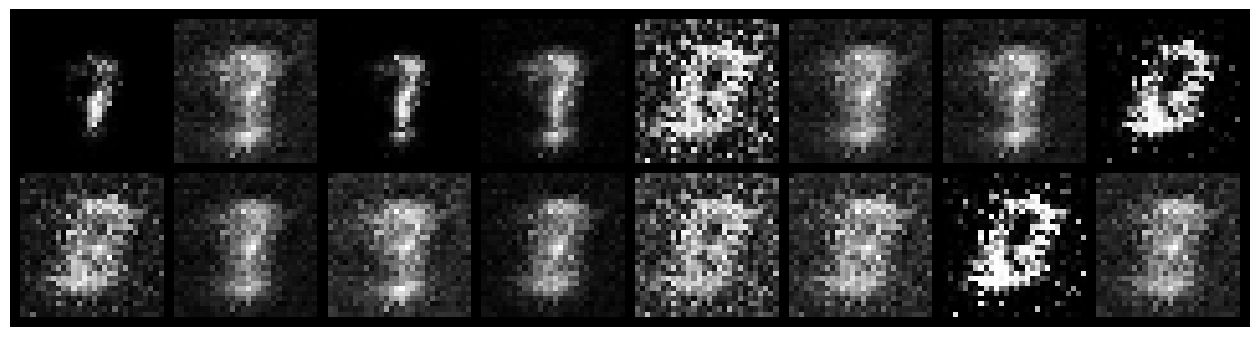

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.5025, Generator Loss: 2.8681
D(x): 0.8332, D(G(z)): 0.1305


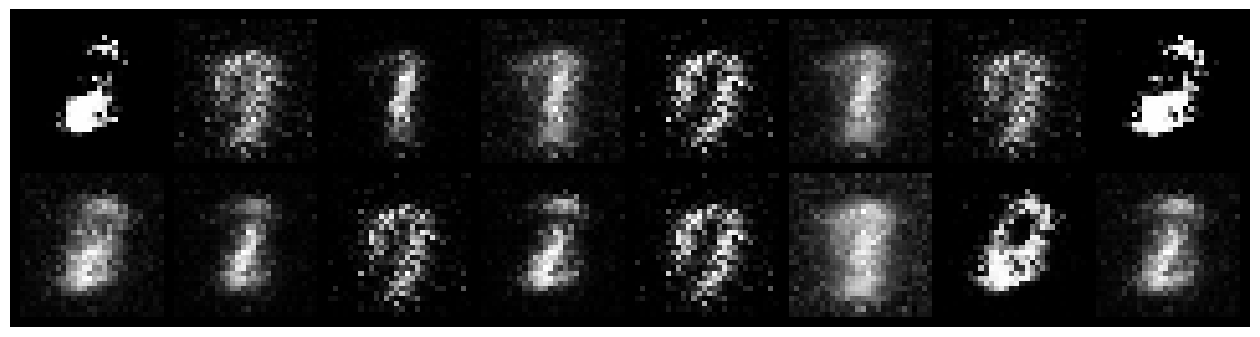

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.6045, Generator Loss: 2.7252
D(x): 0.8494, D(G(z)): 0.2343


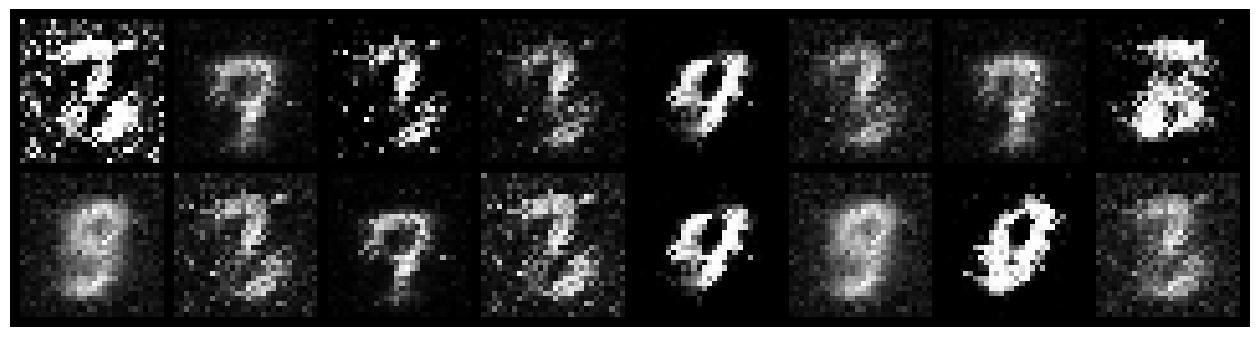

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.8290, Generator Loss: 1.5721
D(x): 0.7283, D(G(z)): 0.2973


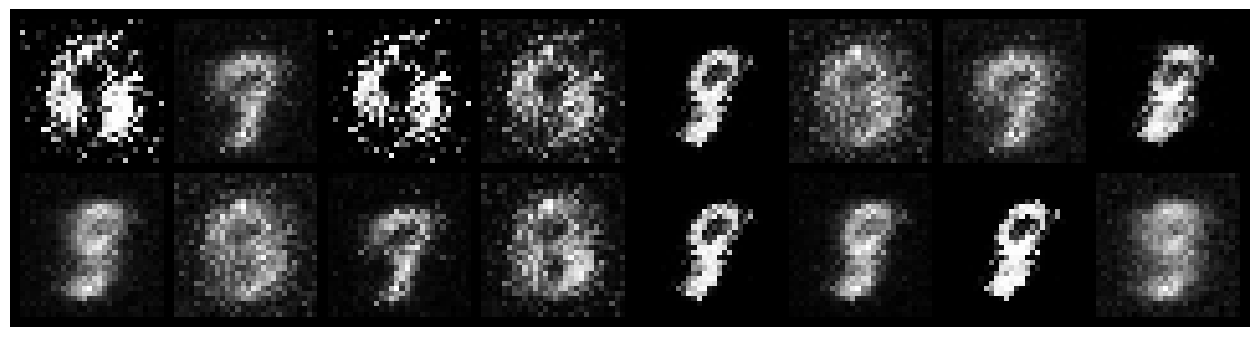

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.7492, Generator Loss: 1.7312
D(x): 0.7806, D(G(z)): 0.2585


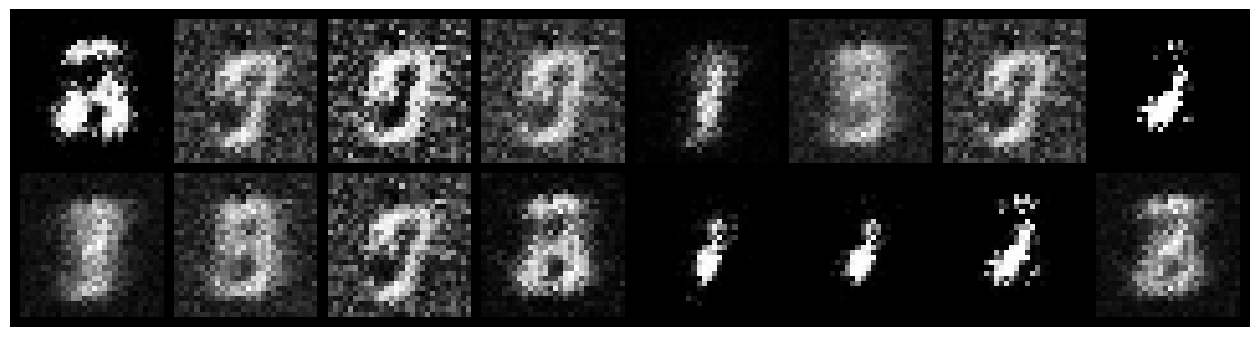

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.8035, Generator Loss: 2.8378
D(x): 0.8066, D(G(z)): 0.2247


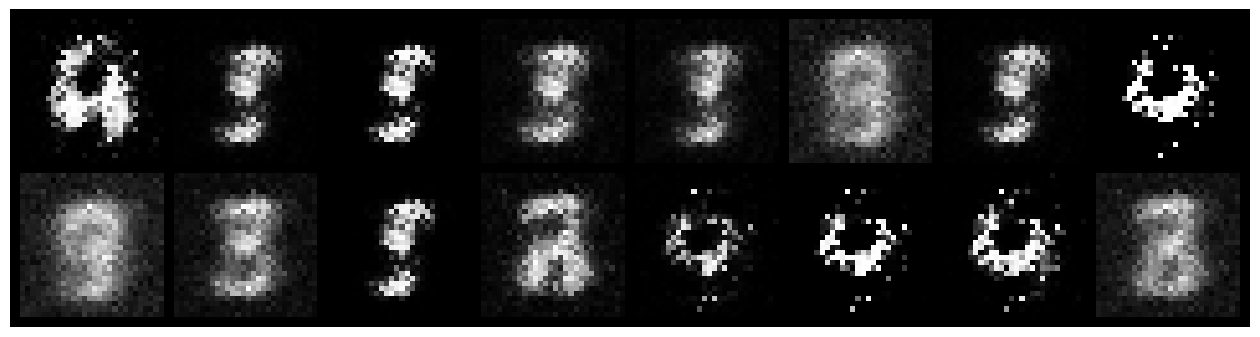

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.3277, Generator Loss: 3.1789
D(x): 0.8868, D(G(z)): 0.1336


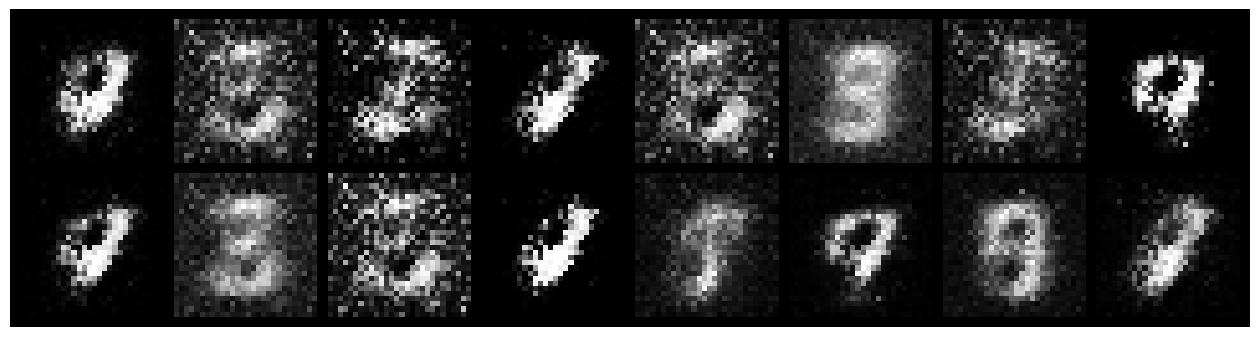

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.8800, Generator Loss: 1.7725
D(x): 0.7370, D(G(z)): 0.2367


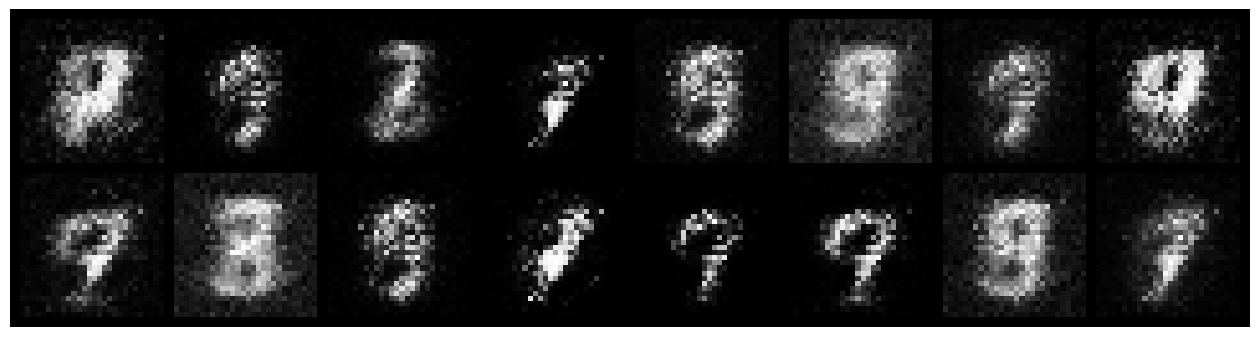

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.6741, Generator Loss: 2.2339
D(x): 0.8408, D(G(z)): 0.2370


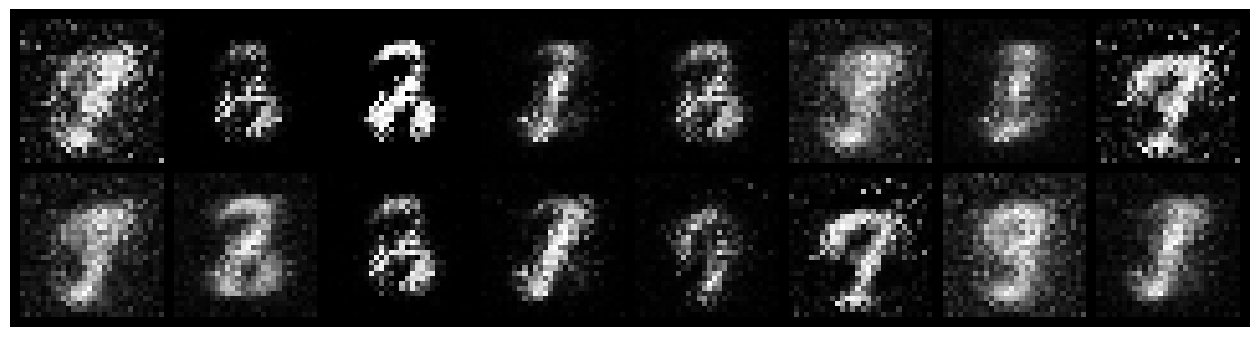

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.4449, Generator Loss: 1.9849
D(x): 0.8414, D(G(z)): 0.1798


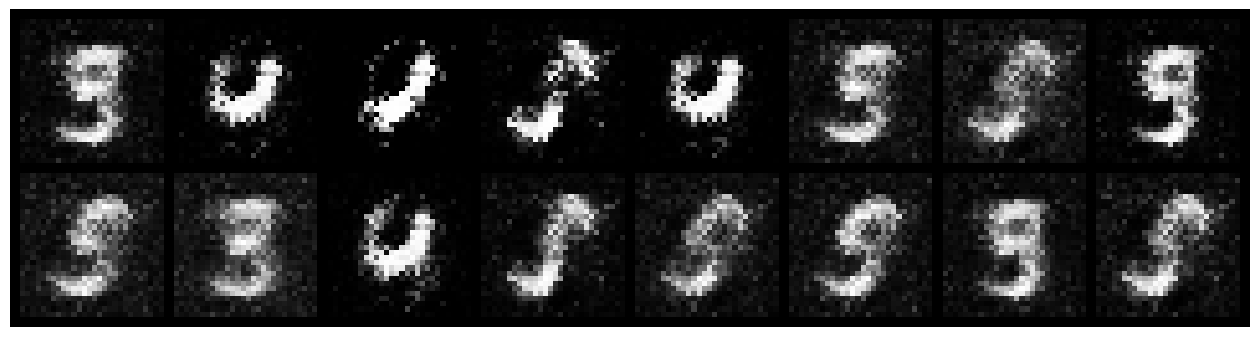

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.6829, Generator Loss: 2.3621
D(x): 0.8783, D(G(z)): 0.2680


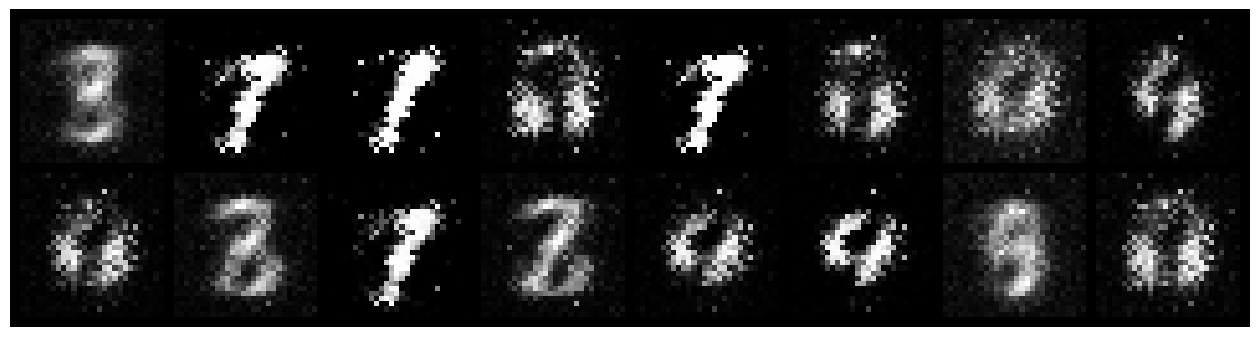

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.4973, Generator Loss: 2.7778
D(x): 0.8251, D(G(z)): 0.1454


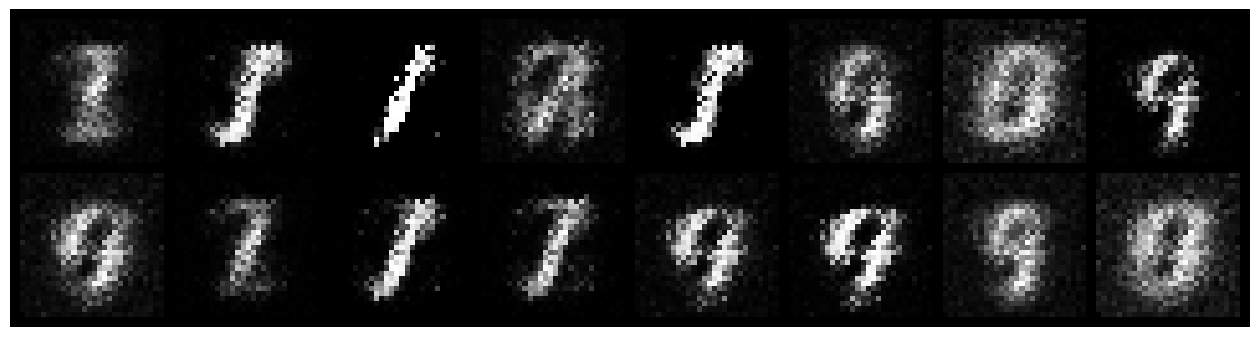

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.3524, Generator Loss: 2.5699
D(x): 0.8672, D(G(z)): 0.1056


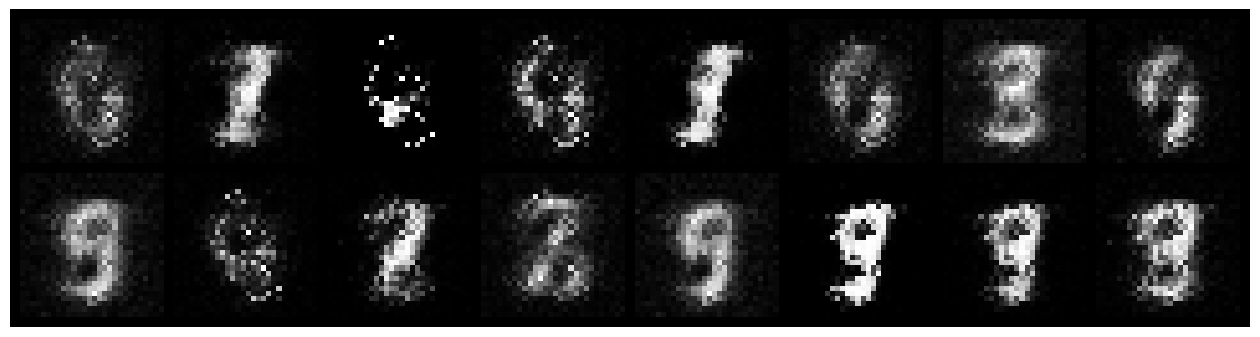

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.5005, Generator Loss: 2.6559
D(x): 0.8669, D(G(z)): 0.1764


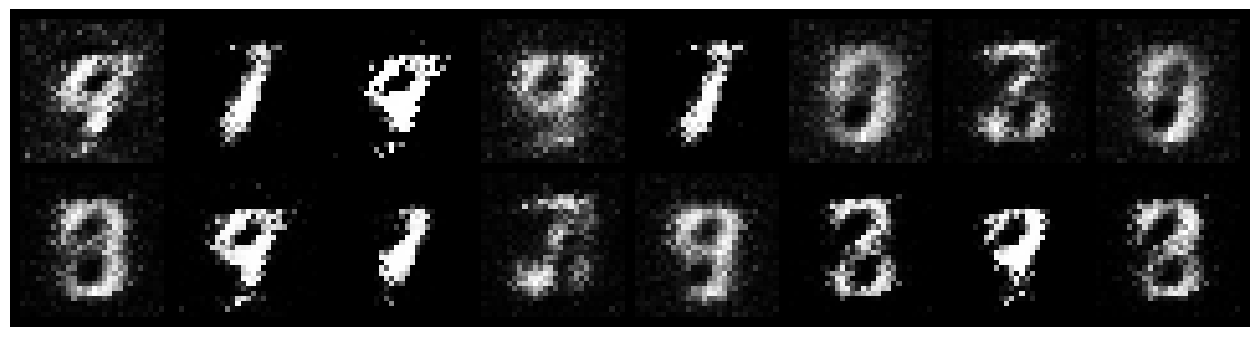

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.5738, Generator Loss: 1.9697
D(x): 0.8346, D(G(z)): 0.2211


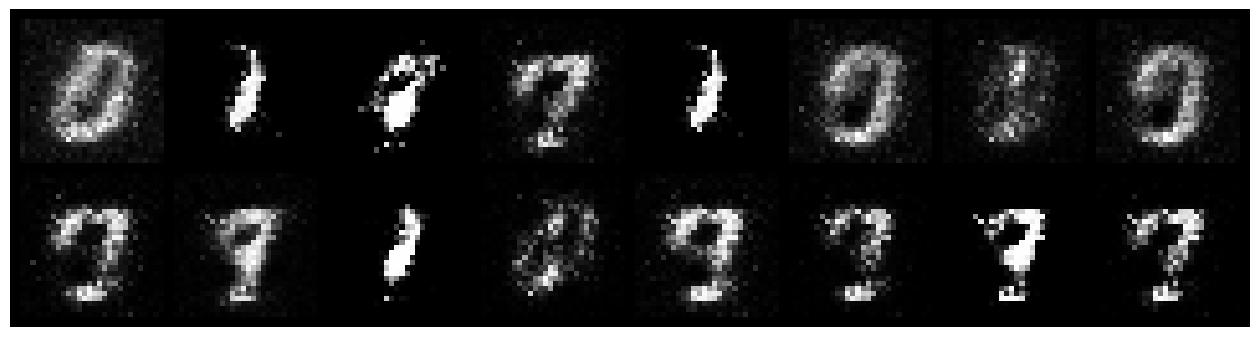

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.7743, Generator Loss: 2.3861
D(x): 0.7118, D(G(z)): 0.2029


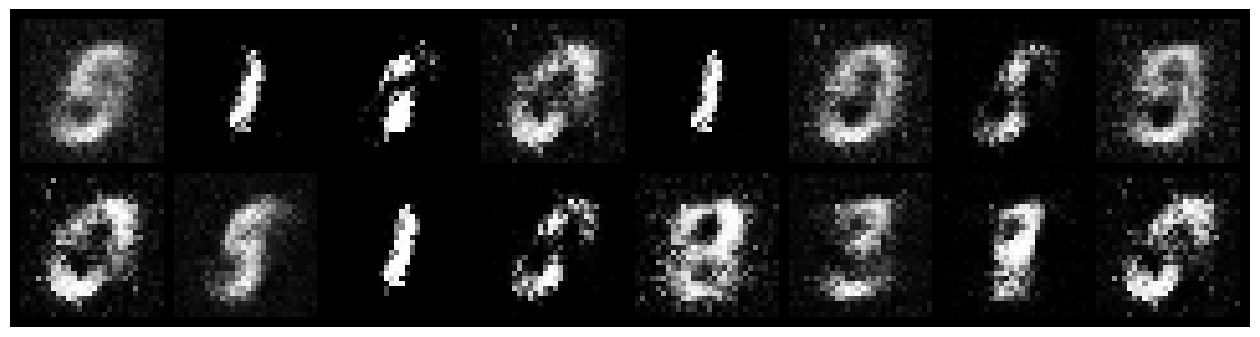

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.6538, Generator Loss: 2.6997
D(x): 0.8087, D(G(z)): 0.1698


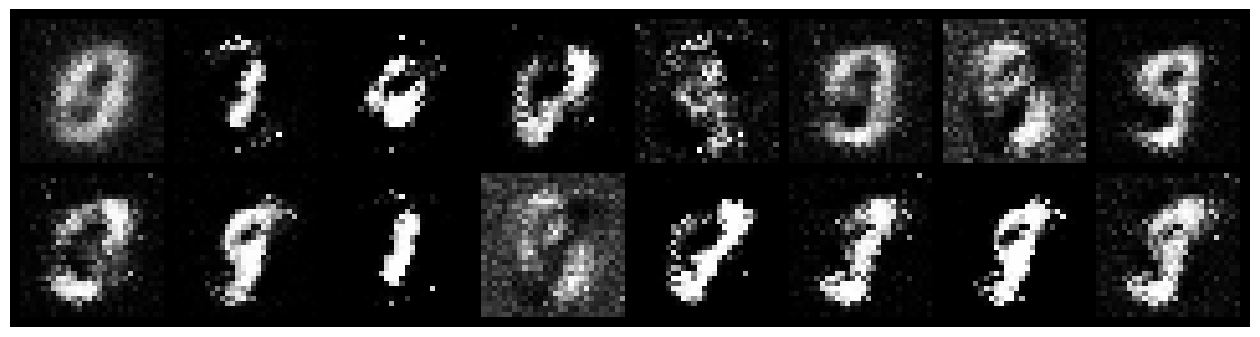

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.6417, Generator Loss: 2.7992
D(x): 0.7909, D(G(z)): 0.1754


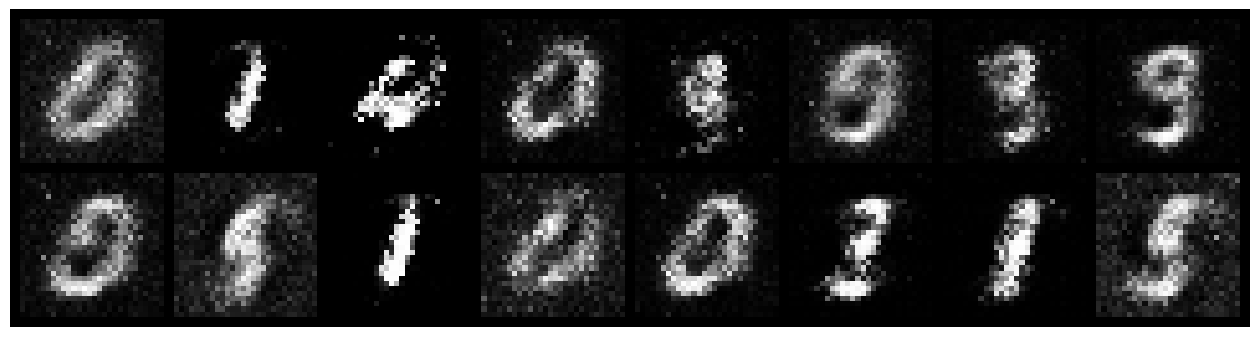

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.4341, Generator Loss: 2.9214
D(x): 0.9070, D(G(z)): 0.1771


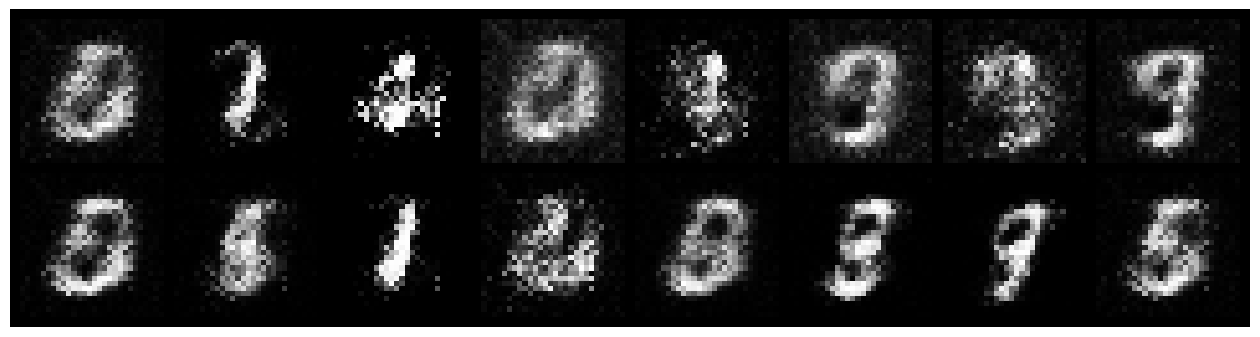

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.4570, Generator Loss: 2.7672
D(x): 0.8754, D(G(z)): 0.1953


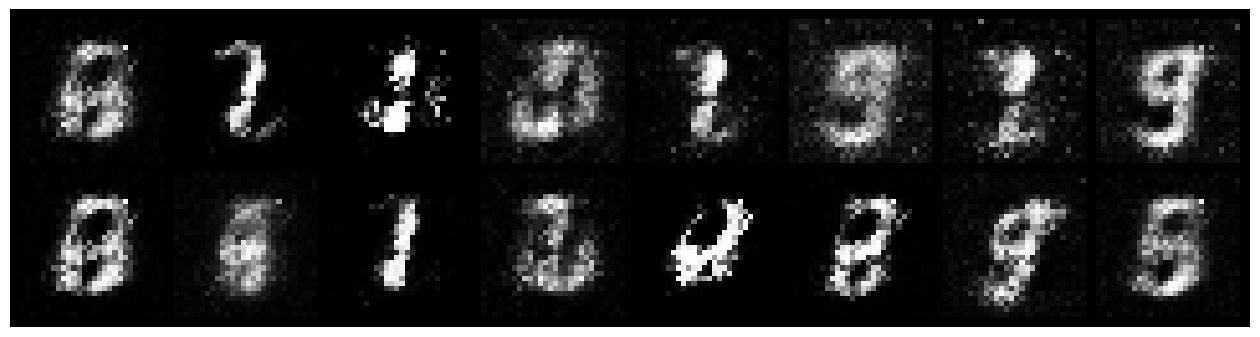

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.6636, Generator Loss: 1.7620
D(x): 0.7648, D(G(z)): 0.2088


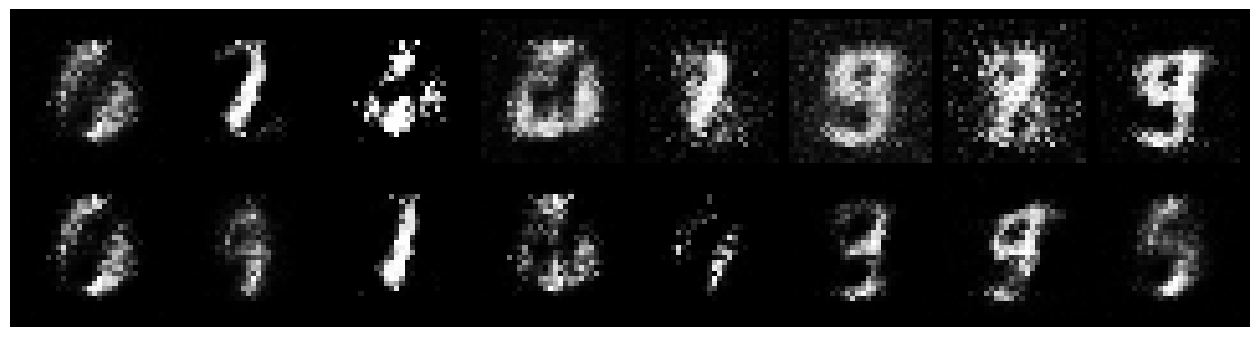

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.7005, Generator Loss: 2.0445
D(x): 0.7442, D(G(z)): 0.1998


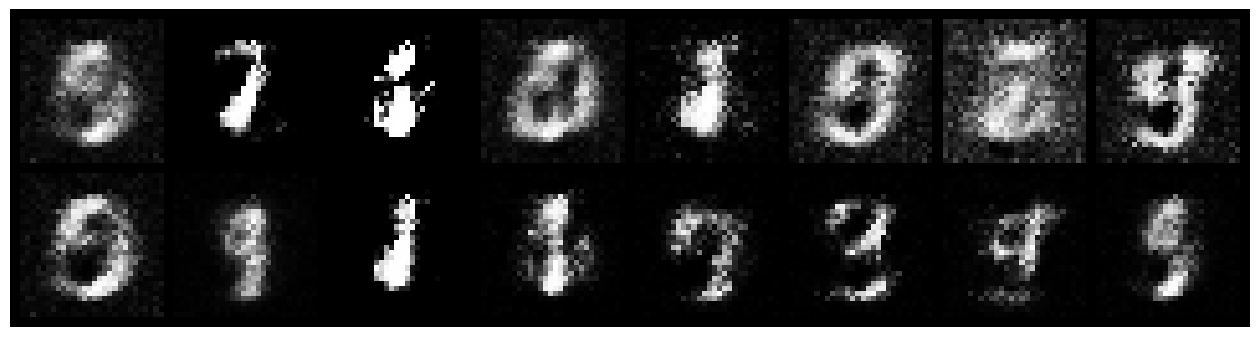

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.6495, Generator Loss: 1.8904
D(x): 0.8541, D(G(z)): 0.2600


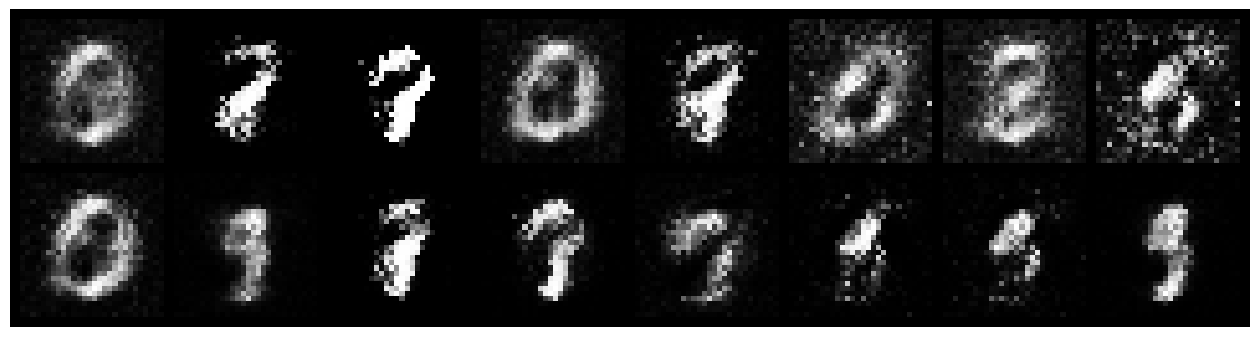

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 1.5862, Generator Loss: 1.4866
D(x): 0.7423, D(G(z)): 0.4724


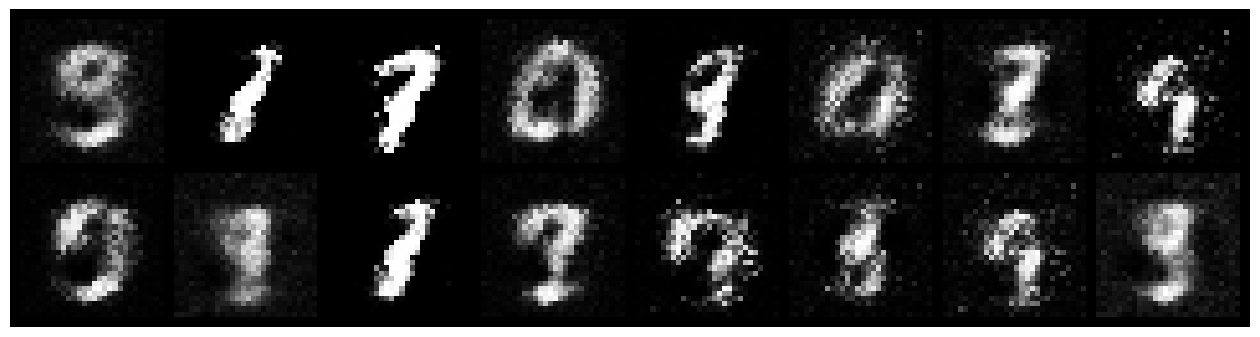

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.7664, Generator Loss: 1.9758
D(x): 0.7271, D(G(z)): 0.2202


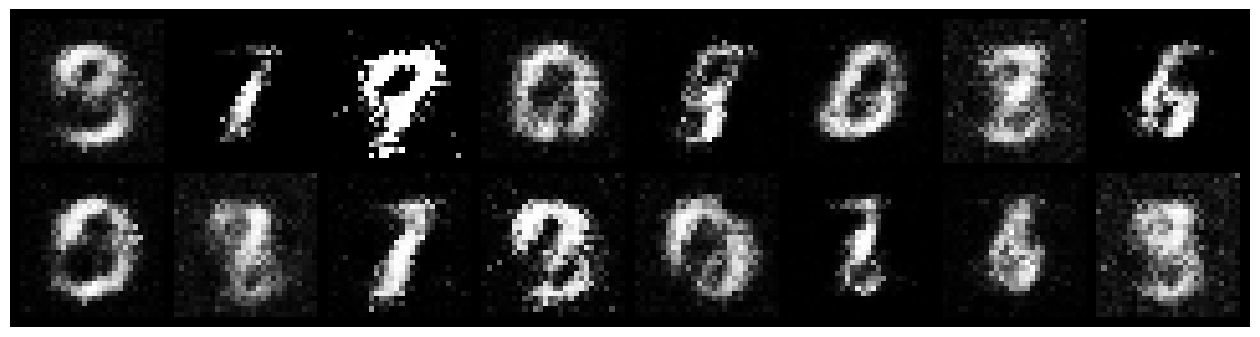

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.7130, Generator Loss: 1.9692
D(x): 0.7563, D(G(z)): 0.2383


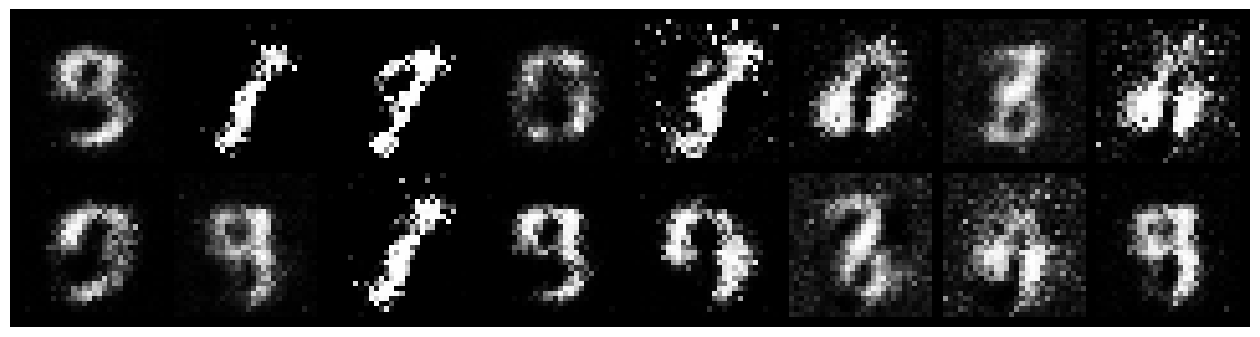

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.5094, Generator Loss: 2.1856
D(x): 0.9042, D(G(z)): 0.2419


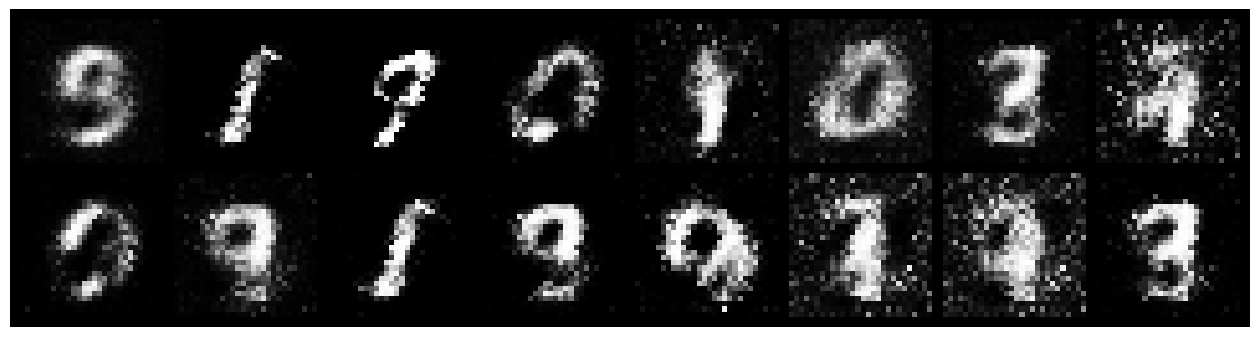

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.4397, Generator Loss: 2.7675
D(x): 0.8254, D(G(z)): 0.1054


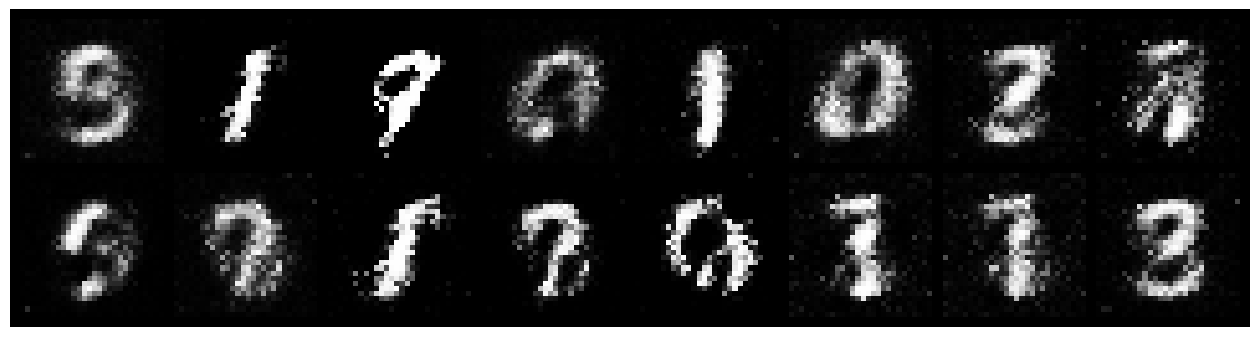

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.5835, Generator Loss: 2.1542
D(x): 0.8344, D(G(z)): 0.2313


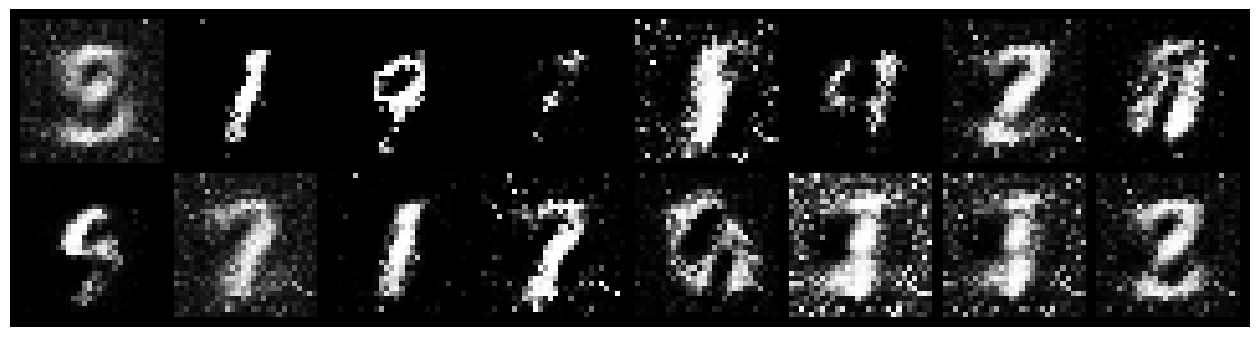

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.5464, Generator Loss: 2.5151
D(x): 0.8543, D(G(z)): 0.2007


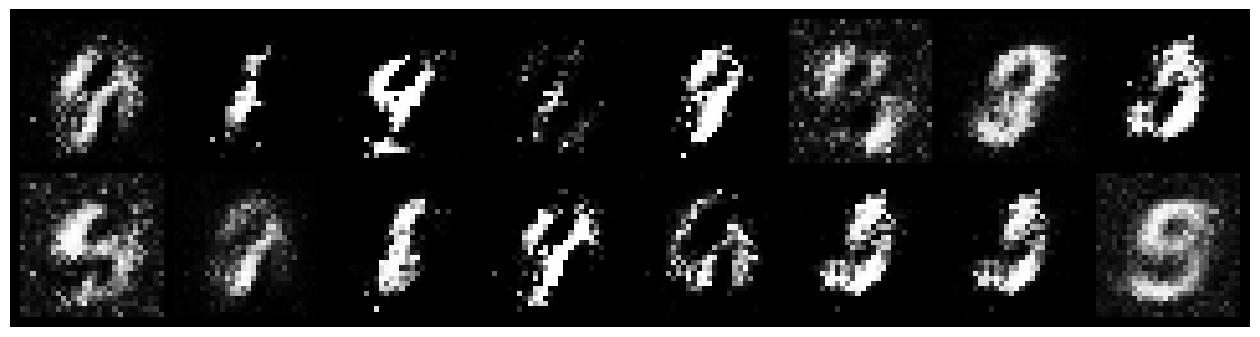

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.5115, Generator Loss: 2.5301
D(x): 0.9034, D(G(z)): 0.2507


KeyboardInterrupt: 

In [24]:
logger = Logger('VGAN', 'MNIST')
num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        # Batch size
        N = real_batch.size(0)

        # 1. Train Discriminator
        real_data = real_batch.view(-1, 28*28)
        fake_data = generator(noise(N)).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train the Generator
        latent_data = generator(noise(N))
        g_error = train_generator(g_optimizer, latent_data)

        # 3. Logging
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if n_batch % 100 == 0:
            test_images = generator(test_noise).view(-1, 1, 28, 28).data
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
            logger.display_status(epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake)

## DCGAN (CNN) - CIFAR

Sources:
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://www.kaggle.com/code/bunnyyy/gan-implementation-from-scratch-using-pytorch

In [25]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [37]:
# Root directory for dataset
dataroot = "./data"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

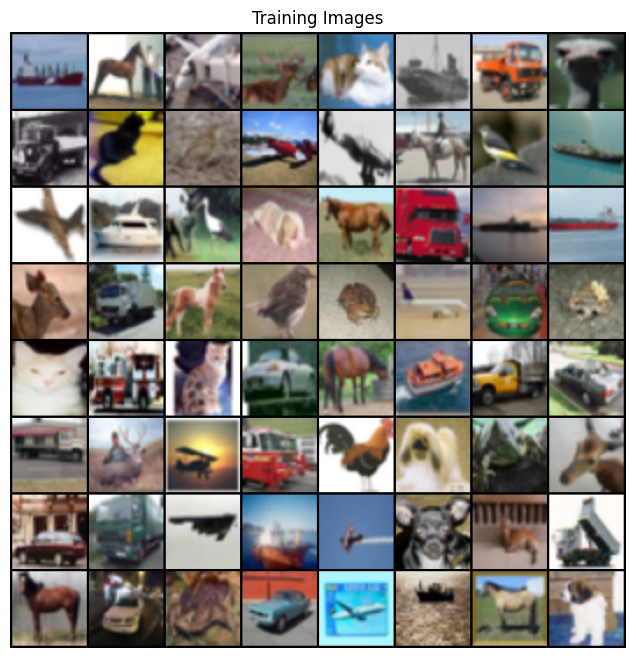

In [39]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.CIFAR10(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [40]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [41]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [42]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [43]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [44]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [45]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [46]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/391]	Loss_D: 1.9833	Loss_G: 3.0748	D(x): 0.3099	D(G(z)): 0.3413 / 0.0596
[0/5][50/391]	Loss_D: 0.9499	Loss_G: 22.0142	D(x): 0.9163	D(G(z)): 0.5343 / 0.0000


KeyboardInterrupt: 

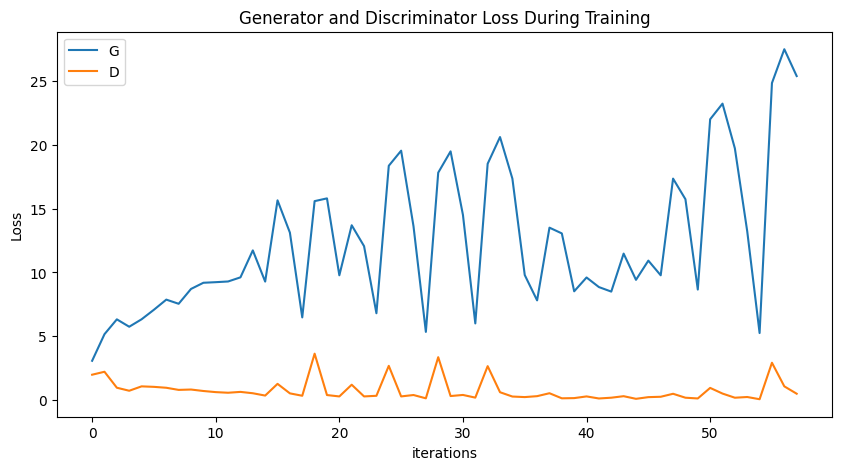

In [47]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

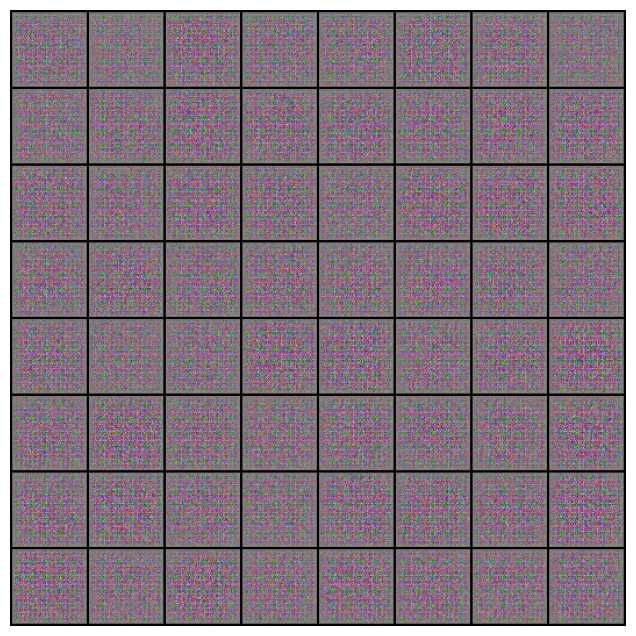

In [48]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


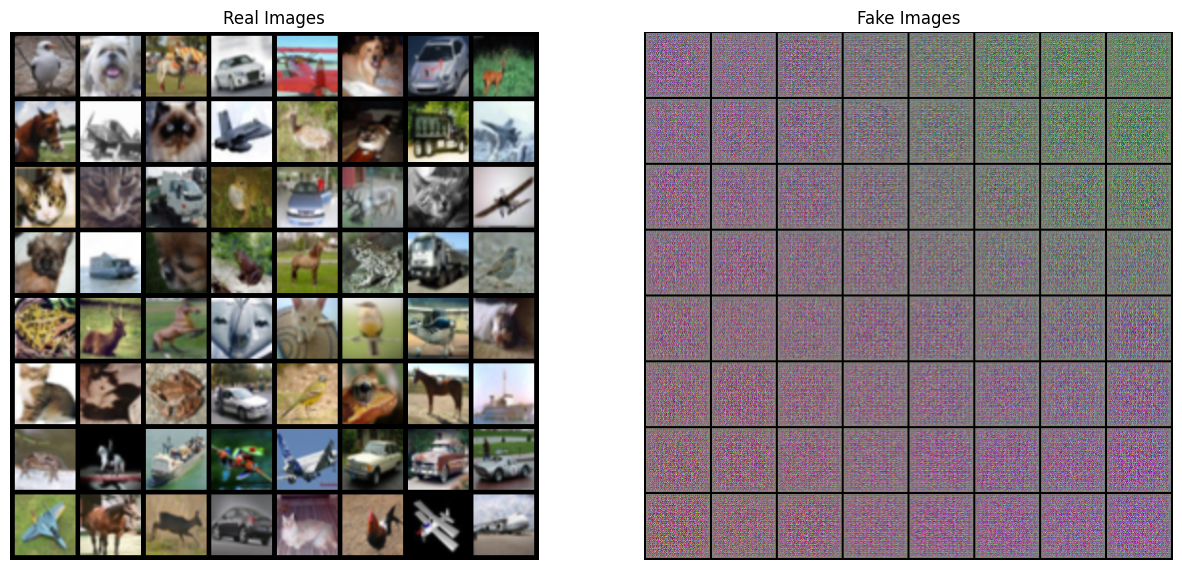

In [49]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()